In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [31]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from concurrent.futures import ThreadPoolExecutor
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping
from google.colab import files
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Image Processing

(200, 300, 3)


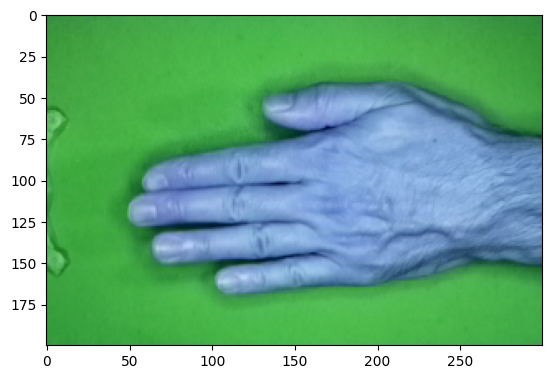

In [4]:
img = cv2.imread("/content/drive/MyDrive/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png")
plt.imshow(img)
print(img.shape)

In [5]:
images, labels = [], []
folders = ["paper", "rock", "scissors"]
label_dict = {"paper": "paper", "rock": "rock", "scissors": "scissors"}

def process_image(folder, filename):
  img_path = os.path.join("/content/drive/MyDrive/rockpaperscissors/", folder, filename)
  image = cv2.imread(img_path)
  resized_image = cv2.resize(image, (200, 130))
  label = label_dict[folder]
  return resized_image, label

with ThreadPoolExecutor() as executor:
  for folder in folders:
    folder_path = os.path.join("/content/drive/MyDrive/rockpaperscissors/", folder)
    image_files = [filename for filename in os.listdir(folder_path) if filename.endswith(".png")]
    results = [executor.submit(process_image, folder, filename) for filename in image_files]
    for future in results:
      resized_image, label = future.result()
      images.append(resized_image)
      labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [6]:
train_image, val_images, train_label, val_labels = train_test_split(images, labels, test_size=0.3, random_state=212)
val_image, test_image, val_label, test_label = train_test_split(val_images, val_labels, test_size=0.67, random_state=125)
train_image = train_image / 255
test_image = test_image / 255
val_image = val_image / 255
encode_labels = LabelBinarizer()
train_label = encode_labels.fit_transform(train_label)
test_label = encode_labels.fit_transform(test_label)
val_label = encode_labels.fit_transform(val_label)
print("Train Image Shape:", train_image.shape)
print("Test Image Shape:", test_image.shape)
print("Val Image Shape:", val_image.shape)
print("Train Labels Shape:", train_label.shape)
print("Test Labels Shape:", test_label.shape)
print("Val Labels Shape:", val_label.shape)

Train Image Shape: (1531, 130, 200, 3)
Test Image Shape: (441, 130, 200, 3)
Val Image Shape: (216, 130, 200, 3)
Train Labels Shape: (1531, 3)
Test Labels Shape: (441, 3)
Val Labels Shape: (216, 3)


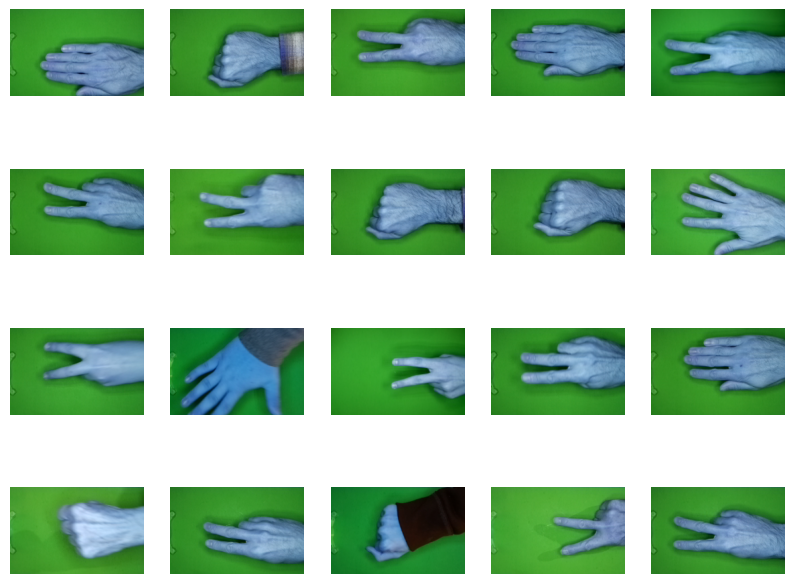

In [7]:
plt.figure(figsize=(10, 10))
for i in range(20):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_image[i])
  plt.axis('off')
plt.show()

# Augmentation Data

In [8]:
datagen = ImageDataGenerator(
    rotation_range=40,      # Rentang rotasi gambar
    width_shift_range=0.2,  # Rentang pergeseran horizontal
    height_shift_range=0.2, # Rentang pergeseran vertikal
    shear_range=0.2,        # Rentang pergeseran sudut (shear)
    zoom_range=0.2,         # Rentang zoom
    horizontal_flip=True   # Flip horizontal
)
train_generator = datagen.flow(train_image, train_label, batch_size=16)

# Models

In [9]:
def create_model(act, opt, drp):
  model = Sequential()
  ''' Convolutional Layer '''
  model.add(Conv2D(filters=32, kernel_size=2, activation=act, input_shape=(130, 200, 3)))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=128, kernel_size=2, activation=act))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=128, kernel_size=2, activation=act))
  model.add(MaxPool2D(pool_size=2))
  model.add(Flatten())
  ''' Hidden Layer '''
  model.add(Dense(128,activation=act))
  model.add(Dropout(drp))
  model.add(Dense(64,activation=act))
  model.add(Dropout(0.2))
  ''' Classification Layer '''
  model.add(Dense(3,activation='softmax'))
  ''' Compile Model '''
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [13]:
hyperparameters = {
  'activation': ['relu', 'tanh', 'sigmoid'],
  'optimizer': ['adam', 'sgd', 'rmsprop'],
  'dropout' : [0.3, 0.4, 0.5]
}

best_accuracy = 0.0
best_model = None
best_hyperparameters = {}

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  for activation in hyperparameters['activation']:
    for optimizer in hyperparameters['optimizer']:
      for dropout in hyperparameters['dropout']:
        print(f"Training model with activation={activation}, optimizer={optimizer}, dropout={dropout}")
        model = create_model(activation, optimizer, dropout)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
        history = model.fit(train_generator, validation_data=(val_image, val_label), epochs=50, callbacks=[early_stopping], verbose=0)
        val_loss, val_accuracy = model.evaluate(val_image, val_label, verbose=0)
        print(f"Validation accuracy: {val_accuracy}")
        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model = model
          best_history = history
          best_hyperparameters = {'activation': activation, 'optimizer': optimizer, 'dropout':dropout}

print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy: {}".format(best_accuracy))

Training model with activation=relu, optimizer=adam, dropout=0.3
Validation accuracy: 0.9814814925193787
Training model with activation=relu, optimizer=adam, dropout=0.4
Validation accuracy: 0.9953703880310059
Training model with activation=relu, optimizer=adam, dropout=0.5
Validation accuracy: 0.9953703880310059
Training model with activation=relu, optimizer=sgd, dropout=0.3
Validation accuracy: 0.9490740895271301
Training model with activation=relu, optimizer=sgd, dropout=0.4
Validation accuracy: 0.8703703880310059
Training model with activation=relu, optimizer=sgd, dropout=0.5
Validation accuracy: 0.9490740895271301
Training model with activation=relu, optimizer=rmsprop, dropout=0.3
Validation accuracy: 0.9861111044883728
Training model with activation=relu, optimizer=rmsprop, dropout=0.4
Validation accuracy: 0.9861111044883728
Training model with activation=relu, optimizer=rmsprop, dropout=0.5
Validation accuracy: 0.9907407164573669
Training model with activation=tanh, optimizer=ad

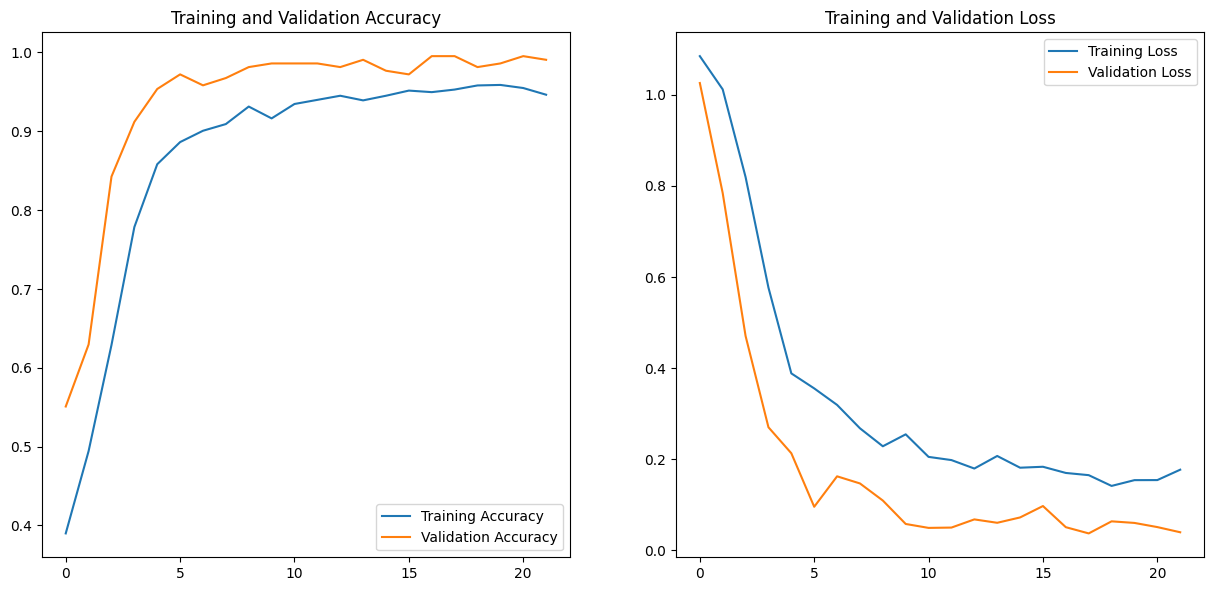

In [28]:
epochs_range = range(len(best_history.epoch))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, best_history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, best_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, best_history.history['loss'], label='Training Loss')
plt.plot(epochs_range, best_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
test_loss, test_accuracy = best_model.evaluate(test_image, test_label)
print("Test accuracy: {}".format(test_accuracy))

14/14 [==============================] - 1s 32ms/step - loss: 0.0491 - accuracy: 0.9909
Test accuracy: 0.9909297227859497


14/14 [==============================] - 1s 16ms/step


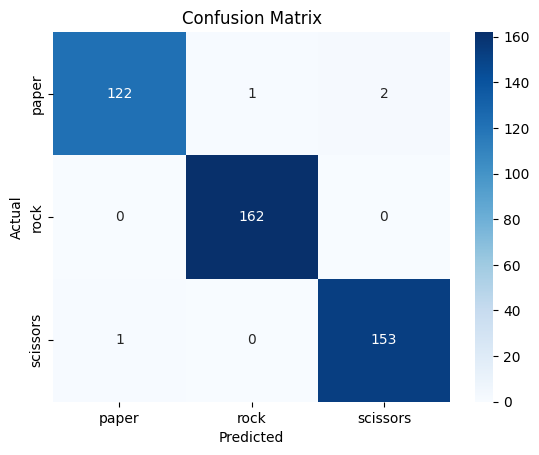

In [32]:
y_pred = best_model.predict(test_image)
cm = confusion_matrix(np.argmax(test_label, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.sort(np.array(["paper", "rock", "scissors"])), yticklabels=np.sort(np.array(["paper", "rock", "scissors"])))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Predictions

In [34]:
def image_predictions(model):
  def prediksi(image, model):
    image = cv2.resize(image, (200, 130))
    img = image / 255
    img= np.reshape(img, (1, 130, 200, 3))
    pred = encode_labels.inverse_transform(model.predict(img, verbose=0))
    return pred[0]
  uploaded = files.upload()
  file_name = list(uploaded.keys())[0]
  print("Predicted:", prediksi(cv2.imread(file_name), model))
  img = mpimg.imread(file_name)
  plt.imshow(img)

Saving 2O9XPBJRT119drWX.png to 2O9XPBJRT119drWX.png
Predicted: rock


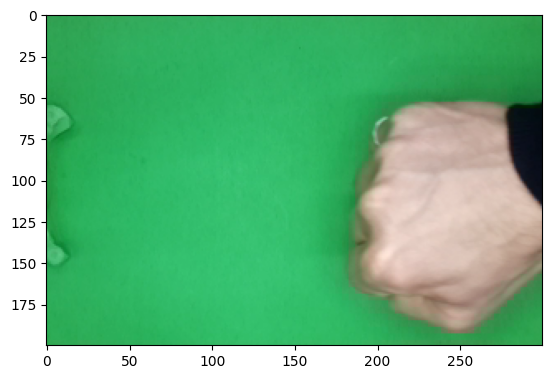

In [35]:
image_predictions(best_model)

panggil fungsi image_predictions() untuk upload gambar dan memprediksi